# Kerri's Sample DeepRacer Training Analysis Notebook 

This notebook is based on the work of the DeepRacer Community and AWS DeepRacer Team. 

Setting the stage; assuming we have just completed a training session in the AWS DeepRacer console backed by SageMaker and now wish to analyze what our virtual car has learned we would use a notebook similar to this to view our results. 


## Imports

Executing the following block will run the import statements below.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown, track_meta
from deepracer.logs import \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu, \
    DeepRacerLog

# Ignore deprecation warnings
import warnings
warnings.filterwarnings('ignore')

## Get the logs

This block of code will pull logs from the samples included in the project. We would normally use the awscli interface to pull the logs out of our AWS account directly. 
    

In [10]:
model_logs_root = 'logs/sample-logs'
log = DeepRacerLog(model_logs_root)

# load logs into a dataframe
log.load()

try:
    pprint(log.agent_and_network())
    print("-------------")
    pprint(log.hyperparameters())
    # print("-------------")
    # pprint(log.action_space())
except Exception:
    print("Robomaker logs not available")

df = log.dataframe()

{'network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'sensor_list': ['LIDAR', 'STEREO_CAMERAS'],
 'simapp_version': '2.0',
 'world': 'reinvent_base'}
-------------
{'batch_size': 64,
 'beta_entropy': 0.01,
 'discount_factor': 0.99,
 'e_greedy_value': 1.0,
 'epsilon_steps': 10000,
 'exploration_type': 'categorical',
 'loss_type': 'huber',
 'lr': 0.0001,
 'num_episodes_between_training': 40,
 'num_epochs': 10,
 'stack_size': 1,
 'term_cond_avg_score': 100000.0,
 'term_cond_max_episodes': 100000}


If the code above completed successfully we will see details printed about the agent and the network. Next we will see what we loaded into the datafram by using the `head()` method to print out the first few rows of data.


In [11]:
df.head()

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp,episode_status,iteration,worker,unique_episode
0,0,1.0,3.050016,0.683241,0.031439,-30.0,1.2,1,5.001,False,True,0.792348,0,17.671677,1.597005e+09,in_progress,0,0,0
1,0,2.0,3.055256,0.680791,-0.820364,-30.0,1.2,1,5.001,False,True,0.821993,0,17.671677,1.597005e+09,in_progress,0,0,0
2,0,3.0,3.073026,0.672996,-3.583047,-15.0,0.6,2,5.001,False,True,0.922532,0,17.671677,1.597005e+09,in_progress,0,0,0
3,0,4.0,3.104088,0.658049,-8.112461,0.0,0.6,4,5.001,False,True,1.098275,0,17.671677,1.597005e+09,in_progress,0,0,0
4,0,5.0,3.161865,0.629708,-14.655060,15.0,0.6,6,5.001,False,True,1.425167,1,17.671677,1.597005e+09,in_progress,0,0,0


Loaded 71 waypoints


<AxesSubplot:>

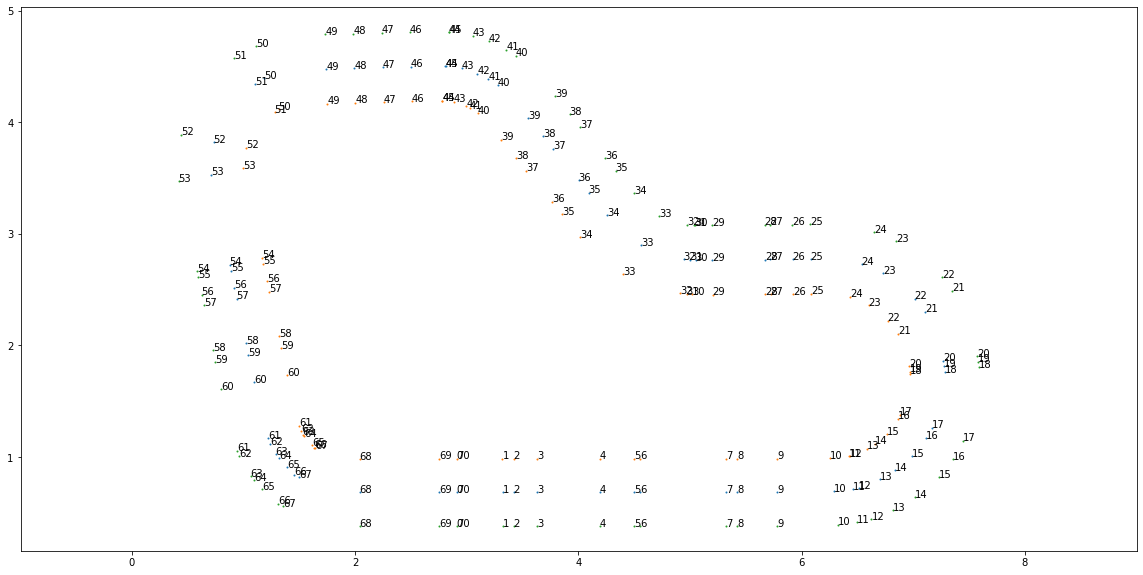

In [12]:
tu = TrackIO()

try:
    track_name = log.agent_and_network()["world"]
except Exception as e:
    track_name = "reinvent_base"


track: Track = tu.load_track(track_name)

pu.plot_trackpoints(track)

### Stats for all laps

Previous graphs were mainly focused on the state of training with regards to training progress. This however will not give you a lot of information about how well your reward function is doing overall.

In such case `scatter_aggregates` may come handy. It comes with three types of graphs:
* progress/steps/reward depending on the time of an episode - of this I find reward/time and new_reward/time especially useful to see that I am rewarding good behaviours - I expect the reward to time scatter to look roughly triangular
* histograms of time and progress - for all episodes the progress one is usually quite handy to get an idea of model's stability
* progress/time_if_complete/reward to closest waypoint at start - these are really useful during training as they show potentially problematic spots on track. It can turn out that a car gets best reward (and performance) starting at a point that just cannot be reached if the car starts elsewhere, or that there is a section of a track that the car struggles to get past and perhaps it's caused by an aggressive action space or undesirable behaviour prior to that place

Side note: `time_if_complete` is not very accurate and will almost always look better for episodes closer to 100% progress than in case of those 50% and below.

new reward not found, using reward as its values


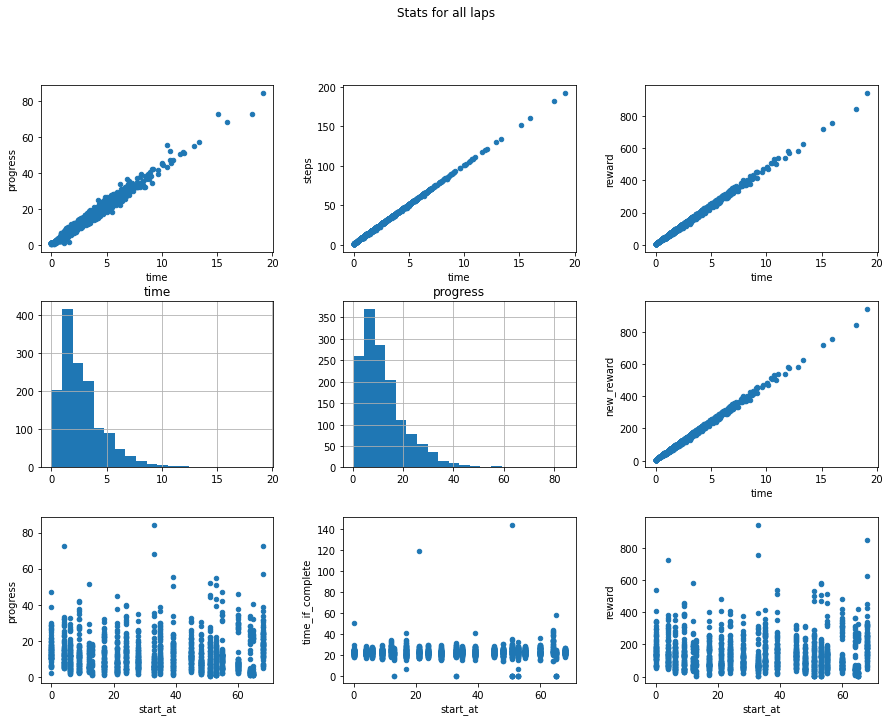

<Figure size 432x288 with 0 Axes>

In [13]:
simulation_agg = au.simulation_agg(df)
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

## Data in tables

While a lot can be seen in graphs that cannot be seen in the raw numbers, the numbers let us get into more detail. Below you will find a couple examples. If your model is behaving the way you would like it to, below tables may provide little added value, but if you struggle to improve your car's performance, they may come handy. In such cases I look for examples where high reward is giving to below-expected episode and when good episodes are given low reward.

You can then take the episode number and scatter it below, and also look at reward given per step - this can in turn draw your attention to some rewarding anomalies and help you detect some unexpected outcomes in your reward function.

There is a number of ways to select the data for display:
* `nlargest`/`nsmallest` lets you display information based on a specific value being highest or lowest
* filtering based on a field value, for instance `df[df['episode']==10]` will display only those steps in `df` which belong to episode 10
* `head()` lets you peek into a dataframe

There isn't a right set of tables to display here and the ones below may not suit your needs. Get to know Pandas more and have fun with them. It's almost as addictive as DeepRacer itself.

The examples have a short comment next to them explaining what they are showing.

In [14]:
# View ten best rewarded episodes in the training
simulation_agg.nlargest(10, 'new_reward')

,iteration,episode,steps,start_at,progress,time,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile
889,22,889,192.0,33,84.265819,19.133441,941.211,0.778125,941.211,22.706052,1116.954666,4th
979,24,979,182.0,68,72.384256,18.127185,844.248,0.771429,844.248,25.042994,1166.342027,4th
389,9,389,160.0,33,67.982932,15.940722,755.205,0.772500,755.205,23.448124,1110.874421,2nd
961,24,961,152.0,4,72.603263,15.114140,720.192,0.813158,720.192,20.817439,991.955411,4th
159,3,159,134.0,68,57.168923,13.326418,626.178,0.756716,626.178,23.310598,1095.311862,1st
115,2,115,130.0,53,54.992941,12.906704,583.197,0.733846,583.197,23.469747,1060.494292,1st
1224,30,1224,120.0,12,51.369546,11.924216,581.139,0.790000,581.139,23.212617,1131.290897,5th
755,18,755,121.0,53,50.666267,12.034118,572.154,0.753719,572.154,23.751737,1129.260219,3rd
411,10,411,117.0,39,50.539773,11.643771,540.162,0.764103,540.162,23.038827,1068.785967,2nd
820,20,820,111.0,0,47.206967,11.029637,537.129,0.778378,537.129,23.364427,1137.817231,3rd


In [15]:
# View five most progressed episodes
simulation_agg.nlargest(5, 'progress')

,iteration,episode,steps,start_at,progress,time,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile
889,22,889,192.0,33,84.265819,19.133441,941.211,0.778125,941.211,22.706052,1116.954666,4th
961,24,961,152.0,4,72.603263,15.114140,720.192,0.813158,720.192,20.817439,991.955411,4th
979,24,979,182.0,68,72.384256,18.127185,844.248,0.771429,844.248,25.042994,1166.342027,4th
389,9,389,160.0,33,67.982932,15.940722,755.205,0.772500,755.205,23.448124,1110.874421,2nd
159,3,159,134.0,68,57.168923,13.326418,626.178,0.756716,626.178,23.310598,1095.311862,1st


In [16]:
# View information for a couple first episodes
simulation_agg.head()

,iteration,episode,steps,start_at,progress,time,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile
0,0,0,41.0,0,17.891366,3.991095,191.055,0.804878,191.055,22.307380,1067.861424,1st
1,0,1,25.0,4,9.455833,2.411682,116.034,0.720000,116.034,25.504700,1227.115545,1st
2,0,2,30.0,6,15.648692,2.905745,145.035,0.840000,145.035,18.568609,926.818649,1st
3,0,3,10.0,9,3.677132,0.900820,45.015,0.780000,45.015,24.497895,1224.187675,1st
4,0,4,44.0,12,17.033865,4.283429,200.064,0.872727,200.064,25.146548,1174.507361,1st


### Path taken for top reward iterations

NOTE: at some point in the past in a single episode the car could go around multiple laps, the episode was terminated when car completed 1000 steps. Currently one episode has at most one lap. This explains why you can see multiple laps in an episode plotted below.

Being able to plot the car's route in an episode can help you detect certain patterns in its behaviours and either promote them more or train away from them. While being able to watch the car go in the training gives some information, being able to reproduce it after the training is much more practical.

Graphs below give you a chance to look deeper into your car's behaviour on track.

We start with plot_selected_laps. The general idea of this block is as follows:
* Select laps(episodes) that have the properties that you care about, for instance, fastest, most progressed, failing in a certain section of the track or not failing in there,
* Provide the list of them in a dataframe into the plot_selected_laps, together with the whole training dataframe and the track info,
* You've got the laps to analyse.

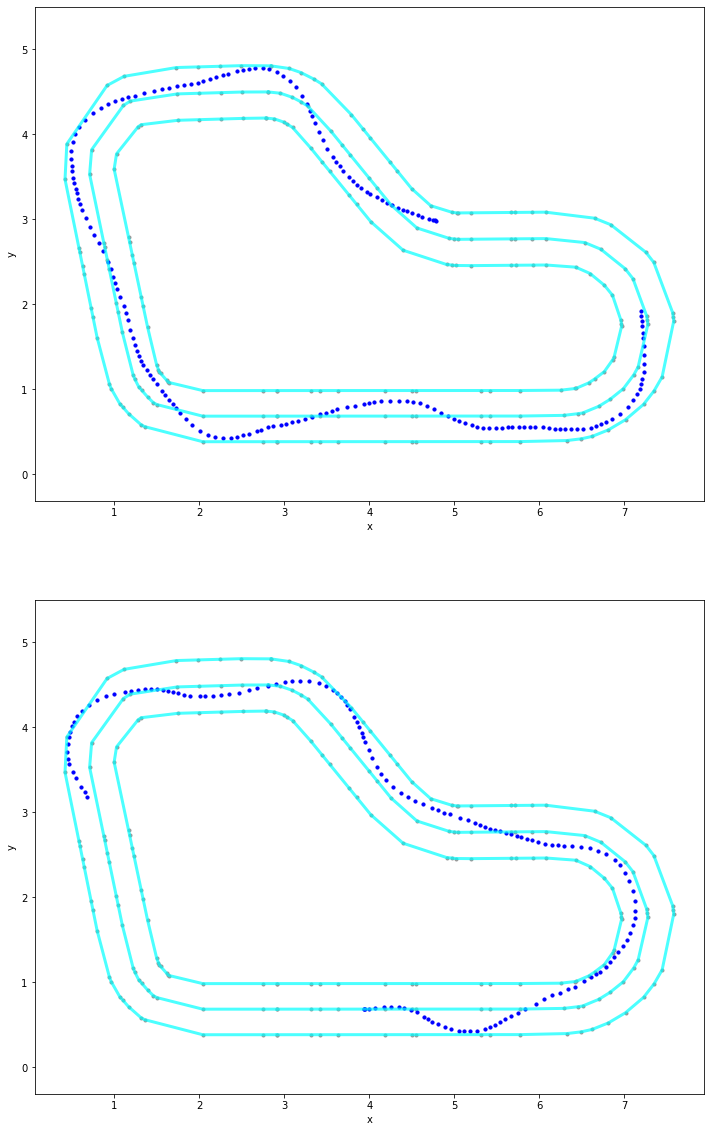

<Figure size 432x288 with 0 Axes>

In [18]:
# Some examples:
# highest reward for complete laps:
# episodes_to_plot = complete_ones.nlargest(3,'reward')

# highest progress from all episodes:
episodes_to_plot = simulation_agg.nlargest(2,'progress')

pu.plot_selected_laps(episodes_to_plot, df, track)

### Path taken in a particular iteration

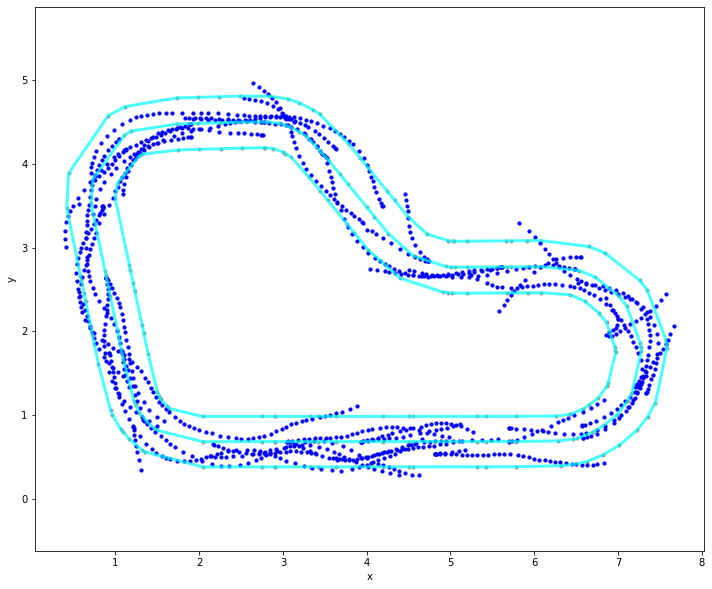

<Figure size 432x288 with 0 Axes>

In [20]:
iteration_id = 10

pu.plot_selected_laps([iteration_id], df, track, section_to_plot = 'iteration')